# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

In [168]:
# import libraries:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

import seaborn as sns
import numpy as np

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [2]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

'kaggle' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [296]:
df= pd.read_csv('Traffic Data.csv')
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
 7   date_time            20000 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB


In [298]:
df['date_time']=pd.to_datetime(df['date_time'])

In [299]:
df=df.set_index('date_time')
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


In [300]:
df['weather_main'].unique()

array(['Mist', 'Clear', 'Clouds', 'Rain', 'Thunderstorm', 'Fog',
       'Drizzle', 'Snow', 'Haze', 'Smoke'], dtype=object)

In [301]:
df['weather_description'].unique()

array(['mist', 'sky is clear', 'broken clouds', 'moderate rain',
       'proximity shower rain', 'proximity thunderstorm', 'fog',
       'light rain', 'overcast clouds', 'light intensity drizzle',
       'scattered clouds', 'proximity thunderstorm with rain',
       'light snow', 'haze', 'few clouds', 'heavy intensity rain', 'snow',
       'drizzle', 'heavy intensity drizzle', 'thunderstorm',
       'Sky is Clear', 'heavy snow', 'thunderstorm with heavy rain',
       'light shower snow', 'shower drizzle',
       'thunderstorm with light rain', 'thunderstorm with rain',
       'thunderstorm with light drizzle',
       'proximity thunderstorm with drizzle', 'smoke',
       'light intensity shower rain', 'sleet', 'light rain and snow',
       'freezing rain'], dtype=object)

In [302]:
encoder= LabelEncoder()
df['weather_description']= encoder.fit_transform(df['weather_description'])

In [303]:
df['weather_main']= encoder.fit_transform(df['weather_main'])

In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-08-27 01:00:00 to 2018-05-31 18:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  int32  
 6   weather_description  20000 non-null  int32  
dtypes: float64(4), int32(2), int64(1)
memory usage: 1.1 MB


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

<Axes: xlabel='date_time'>

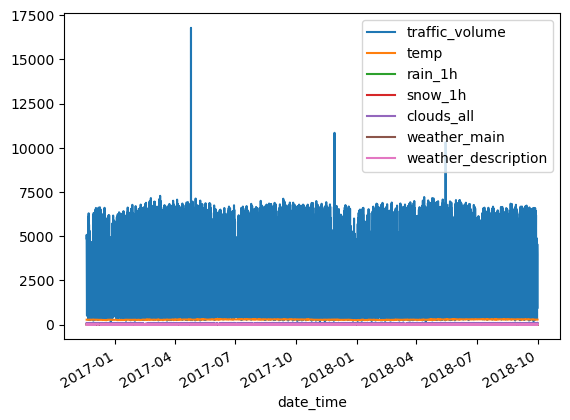

In [305]:
df.plot()

<Axes: >

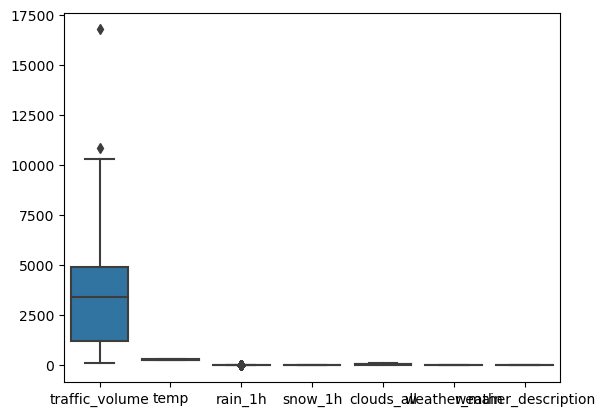

In [306]:
sns.boxplot(df)

In [307]:
#remove outliers from traffic volume:


## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [308]:
#missing values
df.isna().sum()

traffic_volume         20
temp                    0
rain_1h                 0
snow_1h                 0
clouds_all              0
weather_main            0
weather_description     0
dtype: int64

In [309]:
#percentage of null values
df.isna().mean()*100

traffic_volume         0.1
temp                   0.0
rain_1h                0.0
snow_1h                0.0
clouds_all             0.0
weather_main           0.0
weather_description    0.0
dtype: float64

In [310]:
df.shape

(20000, 7)

In [311]:
#handle missing values
df=df.dropna(subset='traffic_volume')

In [312]:
df.duplicated().sum()

18

In [313]:
df=df.drop_duplicates()

In [314]:
#sort index
df=df.sort_index()

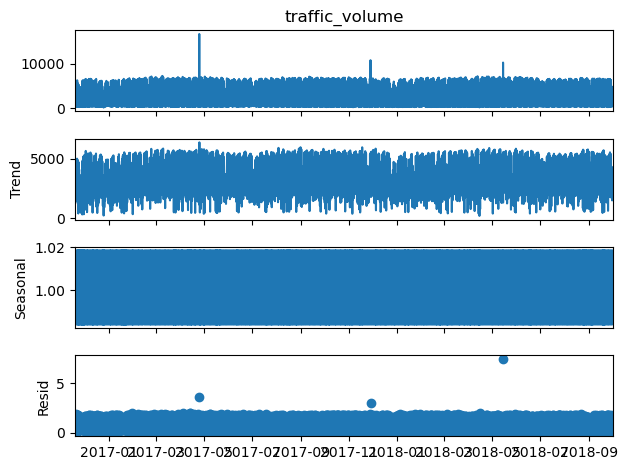

In [315]:
#Seasonal Decomposition
result=seasonal_decompose(df['traffic_volume'], model='multivariate',period=12)
result.plot()
plt.show()

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [316]:
#shift Method:
df['prev_traffic_volume']=df['traffic_volume'].shift(1)

In [317]:
# Difference between traffic_volume
df['diff_traffic_volume'] = df['traffic_volume'].diff()

In [318]:
# Feature extraction:
# Day of the week
df['DayOfWeak']=df.index.dayofweek
# Month
df['Month']=df.index.month

#Day of the year
df['DayOfYear']=df.index.dayofyear

In [319]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,prev_traffic_volume,diff_traffic_volume,DayOfWeak,Month,DayOfYear
date_time,,,,,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,3,4,NaN,NaN,4,11,323
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,5,16,4872.0,0.0,4,11,323
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,8,9,4872.0,0.0,4,11,323
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,5,16,4872.0,202.0,4,11,323
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,3,4,5074.0,0.0,4,11,323


In [320]:
df.isna().sum()

traffic_volume         0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
prev_traffic_volume    1
diff_traffic_volume    1
DayOfWeak              0
Month                  0
DayOfYear              0
dtype: int64

In [321]:
#handle missing values
drop_rows=['diff_traffic_volume','prev_traffic_volume']
df=df.dropna(subset=drop_rows)

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [322]:
#split data  80% for training and 20% for testing
split_data=round(len(df)*0.8)
train_data=df.iloc[:split_data]
test_data=df.iloc[split_data:]

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [323]:
scaler= MinMaxScaler()
train_data= scaler.fit_transform(train_data)
test_data=scaler.transform(test_data)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [324]:
# I want to select GRU , and LSTM models

In [325]:
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0:dataset.shape[1]]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [326]:
X_train, Y_train= create_dataset(train_data,10)
X_test, Y_test = create_dataset(test_data, 10)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [327]:
# GRU model:
model_GRU = Sequential([
    GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(units=64, return_sequences=False),
    Dropout(0.2),
    Dense(units=32),
    Dense(units=1)
])
model_GRU.compile(loss='mean_squared_error', optimizer='adam')
model_GRU.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_18 (GRU)                (None, 10, 64)            14976     
                                                                 
 dropout_23 (Dropout)        (None, 10, 64)            0         
                                                                 
 gru_19 (GRU)                (None, 64)                24960     
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 42049 (164.25 KB)
Trainable params: 420

In [328]:
# train the model:
GRU_history=model_GRU.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/10
499/499 [==============================] - 19s 20ms/step - loss: 0.0066 - val_loss: 0.0025
Epoch 2/10
499/499 [==============================] - 10s 20ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 3/10
499/499 [==============================] - 11s 21ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/10
499/499 [==============================] - 11s 21ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/10
499/499 [==============================] - 11s 21ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 6/10
499/499 [==============================] - 11s 21ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 7/10
499/499 [==============================] - 11s 21ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 8/10
499/499 [==============================] - 11s 21ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 9/10
499/499 [==============================] - 10s 19ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 10/10
499/499 [==============================] - 9s 19ms/step - loss: 0.0013

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [329]:
predicion_GRU= model_GRU.predict(X_test)

125/125 [==============================] - 3s 7ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [330]:
model_GRU.evaluate(X_test,Y_test)

125/125 [==============================] - 1s 7ms/step - loss: 0.0015


0.001518523902632296

In [331]:
#Calculate MSE
mse = mean_squared_error(Y_test, predicion_GRU)
mse

0.0015185239548084453

In [332]:
rmse = np.sqrt(mse)
rmse

0.038968242901219516

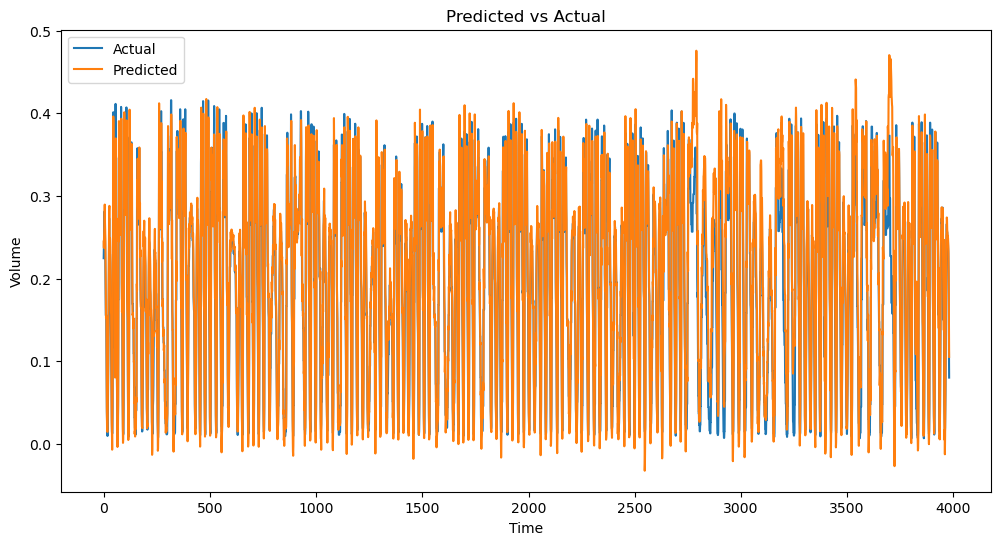

In [333]:
# Plot the predictions against the actual values
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label='Actual')
plt.plot(predicion_GRU, label='Predicted')
plt.title('Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.show()


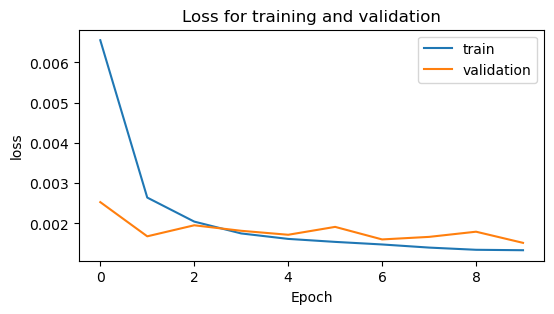

In [334]:
# loss for training and validation
plt.figure(figsize=(6, 3))
plt.plot(GRU_history.history['loss'], label='train')
plt.plot(GRU_history.history['val_loss'], label='Validation')
plt.title('Loss for training and validation')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [335]:
LSTM_model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=64 , return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')
LSTM_model.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 10, 64)            19712     
                                                                 
 dropout_25 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 52801 (206.25 KB)
Trainable params: 52801 (206.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [336]:
LSTM_history=LSTM_model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/10
499/499 [==============================] - 26s 32ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 2/10
499/499 [==============================] - 14s 27ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 3/10
499/499 [==============================] - 10s 19ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 4/10
499/499 [==============================] - 11s 22ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 5/10
499/499 [==============================] - 14s 27ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 6/10
499/499 [==============================] - 14s 28ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 7/10
499/499 [==============================] - 14s 28ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/10
499/499 [==============================] - 14s 29ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 9/10
499/499 [==============================] - 13s 26ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 10/10
499/499 [==============================] - 12s 24ms/step - loss: 0.001

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [337]:
LSTM_predict = LSTM_model.predict(X_test) #Prediction

125/125 [==============================] - 3s 10ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [338]:
# calculate MSE
mse = mean_squared_error(Y_test, LSTM_predict)
mse

0.0014707649169179902

In [339]:
rmse = np.sqrt(mse)
rmse

0.038350553019715246

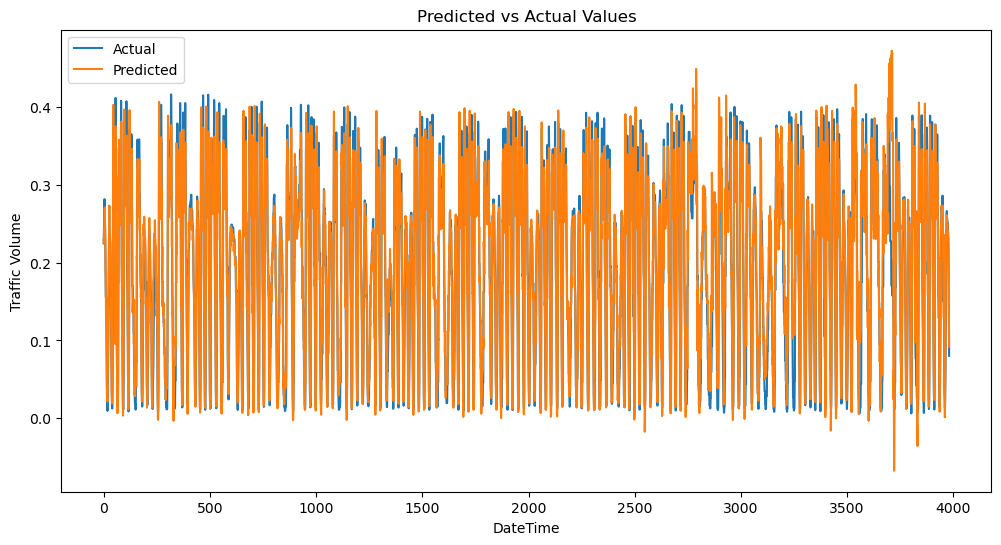

In [340]:
#Plot the predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label='Actual')
plt.plot(LSTM_predict, label='Predicted')
plt.title('Predicted vs Actual Values')
plt.xlabel('DateTime')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

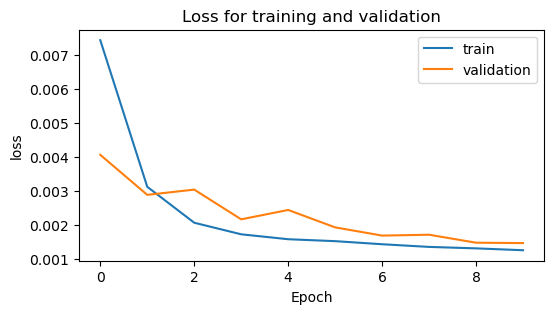

In [341]:
# loss for training and validation
plt.figure(figsize=(6, 3))
plt.plot(LSTM_history.history['loss'], label='train')
plt.plot(LSTM_history.history['val_loss'], label='Validation')
plt.title('Loss for training and validation')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:
- 1. Data preprocessing to insure data cleaning and in the same range by using normaliztion (scaling but a value in range between 0 and 1)
- 2. Feature engineering: To extract extra information from the existing data, like day of week, month, day of year.
- 3. Model Architecture: I used GRU, and LSTM models.
- 4. Training Process: I choose that, epochs=10, batch_size=32, to train the model quickly and save time.
- 5. Loss Function and Metrics: I used mean square error (MSE) to calculate the average of the squared differences between the actual and predicted values.
- 6. Model Tuning:
- 7. verfitting and Underfitting:  I apply dropout to avoid overfitting
- 8. Future Improvements: I will seek improve the performance and using another model like ARIMA.